In [2]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [96]:
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [251]:
def code() -> QuantumCircuit:    #Returns the |0+> State
    qr = QuantumRegister(6, "q")
    cbit = ClassicalRegister(7,"c")
    qc = QuantumCircuit(qr,cbit)
    qc.h(0)
    qc.cx(0,1)
    qc.h(2)
    qc.cx(2,3)
    return qc

def X_L(qc: QuantumCircuit, q: list,n: int)-> QuantumCircuit:
    if n == 1:
        qc.x(q[0])
        qc.x(q[2])
    elif n == 2:
        qc.x(q[0])
        qc.x(q[1])

def Z_L(qc: QuantumCircuit, q: list, n: int)-> QuantumCircuit:
    if n == 1:
        qc.z(q[0])
        qc.z(q[1])
    elif n == 2:
        qc.z(q[0])
        qc.z(q[2])

def CNOT(control: int, q: list) -> QuantumCircuit:
    if control == 1:
        q[0], q[1] = q[1], q[0]
    elif control == 2:
        q[0], q[2] = q[2], q[0]

def H(qc: QuantumCircuit, q:list) -> QuantumCircuit:
    for i in range(4):
        qc.h(q[i])
    q[1], q[2] = q[2], q[1]

def CZ_L(qc: QuantumCircuit, q: list)-> QuantumCircuit:
    for i in range(4):
        qc.s(q[i])
    qc.z(q[1])
    qc.z(q[2])

def T_L(qc:QuantumCircuit, q: list, pos: int)-> QuantumCircuit:
    qc.reset(q[5])
    qc.reset(q[4])

    #qc.h(q[5])
    qc.append(h_ideal,[q[5]])
    qc.t(q[5])

    if pos == 1:
        qc.cx(q[0],q[5])
        qc.cx(q[1],q[5])
    elif pos == 2:
        qc.cx(q[0],q[5])
        qc.cx(q[2],q[5])

    qc.measure(q[5],0)
    qc.reset(q[5])

    if pos == 1:
        with qc.if_test((0,1)):
            #qc.h(q[5])
            qc.append(h_ideal,[q[5]])
            qc.s(q[5])
            qc.cx(q[0],q[5])
            qc.cx(q[1],q[5])
            qc.measure(q[5],0)
            with qc.if_test((0,1)):
                qc.z(q[0])
                qc.z(q[1])
    elif pos == 2:
        with qc.if_test((0,1)):
            #qc.h(q[5])
            qc.append(h_ideal,[q[5]])
            qc.s(q[5])
            qc.cx(q[0],q[5])
            qc.cx(q[2],q[5])
            qc.measure(q[5],0)
            with qc.if_test((0,1)):
                qc.z(q[0])
                qc.z(q[2])

def adj_T_L(qc:QuantumCircuit, q: list, pos: int)-> QuantumCircuit:
    qc.reset(q[5])
    qc.reset(q[4])

    #qc.h(q[5])
    qc.append(h_ideal,[q[5]])
    qc.tdg(q[5])

    if pos == 1:
        qc.cx(q[0],q[5])
        qc.cx(q[1],q[5])
    elif pos == 2:
        qc.cx(q[0],q[5])
        qc.cx(q[2],q[5])

    qc.measure(q[5],0)
    qc.reset(q[5])

    if pos == 1:
        with qc.if_test((0,1)):
            #qc.h(q[5])
            qc.append(h_ideal,[q[5]])
            qc.sdg(q[5])
            qc.cx(q[0],q[5])
            qc.cx(q[1],q[5])
            qc.measure(q[5],0)
            with qc.if_test((0,1)):
                qc.z(q[0])
                qc.z(q[1])
    elif pos == 2:
        with qc.if_test((0,1)):
            #qc.h(q[5])
            qc.append(h_ideal,[q[5]])
            qc.sdg(q[5])
            qc.cx(q[0],q[5])
            qc.cx(q[2],q[5])
            qc.measure(q[5],0)
            with qc.if_test((0,1)):
                qc.z(q[0])
                qc.z(q[2])

def S_L(qc:QuantumCircuit, q: list, pos: int)-> QuantumCircuit:
    qc.reset(q[5])
    qc.reset(q[4])

    #qc.h(q[5])
    qc.append(h_ideal,[q[5]])
    qc.s(q[5])

    if pos == 1:
        qc.cx(q[0],q[5])
        qc.cx(q[1],q[5])
    elif pos == 2:
        qc.cx(q[0],q[5])
        qc.cx(q[2],q[5])

    qc.measure(q[5],0)
    
    if pos == 1:
        with qc.if_test((0,1)):
            qc.z(q[0])
            qc.z(q[1])
    elif pos == 2:
        with qc.if_test((0,1)):
            qc.z(q[0])
            qc.z(q[2])

def adj_S_L(qc:QuantumCircuit, q: list, pos: int)-> QuantumCircuit:
    qc.reset(q[5])
    qc.reset(q[4])

    #qc.h(q[5])
    qc.append(h_ideal,[q[5]])
    qc.sdg(q[5])

    if pos == 1:
        qc.cx(q[0],q[5])
        qc.cx(q[1],q[5])
    elif pos == 2:
        qc.cx(q[0],q[5])
        qc.cx(q[2],q[5])

    qc.measure(q[5],0)
    
    if pos == 1:
        with qc.if_test((0,1)):
            qc.z(q[0])
            qc.z(q[1])
    elif pos == 2:
        with qc.if_test((0,1)):
            qc.z(q[0])
            qc.z(q[2])

def CS_L(qc: QuantumCircuit, q: list, control: int, target: int)-> QuantumCircuit:
    T_L(qc, q, control)
    T_L(qc, q, target)
    CNOT(control, q)
    adj_T_L(qc, q, target)
    CNOT(control, q)

def gates(circuit:QuantumCircuit):
    qc = circuit
    hmm = dict(qc.count_ops())
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

def readout(qc: QuantumCircuit, q: list, pos: int,shots: int, err: float):
    qc.reset(q[4])
    if pos == 1:
        qc.cx(q[0],q[4])
        qc.cx(q[1],q[4])
    elif pos == 2:
        qc.cx(q[0],q[4])
        qc.cx(q[2],q[4])
    qc.measure(q[4],1)

    x_check(qc, q)
    
    for i in range(4):
        qc.measure(q[i],6-i)

    # gates(qc)
    # print(qc.count_ops())

    sim = AerSimulator()
    if err == 0:
        job = sim.run(qc, shots=shots)
    else:
        p = err
        p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
        p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
        job = sim.run(qc, noise_model=noise_model, shots=shots)

    result = job.result()
    counts = result.get_counts()

    return counts

def x_check(qc: QuantumCircuit, q: list):
    qc.reset(q[4])
    # qc.h(q[4])
    # for i in range(4):
    #     qc.cx(q[4],q[i])
    # qc.h(q[4])
    qc.append(h_ideal,[q[4]])
    for i in range(4):
        qc.append(cx_ideal,[q[i],q[4]])
    qc.append(h_ideal,[q[4]])
    qc.measure(q[4], 0)



In [229]:
q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, magic    in this order

qc = code()

T_L(qc, q, 2)
T_L(qc, q, 2)
T_L(qc, q, 2)
T_L(qc, q, 2)

H(qc, q)

counts = readout(qc, q, 2, 1000, 0)

print(counts)

{'1100010': 259, '1001010': 251, '0110010': 269, '0011010': 221}


In [161]:
qr = QuantumRegister(3,"q")

cbits = ClassicalRegister(3,"c")

qc = QuantumCircuit(qr, cbits)

qc.x(0)

qc.measure(0,0)

sim = AerSimulator()
job = sim.run(qc, shots=1000)

result = job.result()
counts = result.get_counts()
x = list(counts.keys())

print(counts)
print(x)
print(x[0][2])

{'001': 1000}
['001']
1


In [352]:
#iQPE first iteration
def iQPE_1(shots: int, err: float):
    q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, s_m, t_m    in this order
    qc = code()

    X_L(qc, q, 1)

    CZ_L(qc, q)

    H(qc, q)

    counts = readout(qc, q, 2, shots, err)

    return counts

shots = 1000
counts = iQPE_1(shots, 0.1)

print(counts)

x = list(counts.keys())
y = list(counts.values())

all = 0

ehm = 0
for i in x:
    if int(i[5]) == 1:
        all += y[ehm]
    ehm += 1

all = all/shots

print("Successrate without any postselection: ", all)

check = [(i.count("1",0,5)%2-1) for i in x]

check = [-i for i in check]

y_new = np.multiply(check, y)

all = 0

for i in range(len(x)):
    if int(x[i][5]) == 1 and check[i] == 1:# and int(x[i][6]) == 0:
        all += y_new[i]

postselec = sum(y_new)

all = all/postselec

print("Successrate with postselection: ", all)


{'1100001': 2, '0111000': 1, '0111001': 1, '1100000': 4, '0101010': 2, '0100010': 1, '1111010': 1, '0001011': 3, '1101001': 1, '0101000': 11, '0011000': 3, '0010011': 20, '1110001': 18, '0110001': 7, '1001011': 30, '0110000': 3, '1001001': 3, '0001001': 13, '1111000': 7, '0111011': 17, '1010011': 1, '0001000': 33, '0110011': 43, '1100011': 50, '0001010': 5, '0000011': 1, '0100000': 26, '1111001': 2, '0011010': 78, '1011000': 31, '1011001': 16, '1101011': 18, '1000010': 36, '1101010': 36, '1010001': 6, '0010010': 29, '1001010': 70, '1100010': 100, '0110010': 77, '0000001': 8, '1110000': 33, '0101001': 14, '0101011': 1, '1000000': 2, '0011001': 3, '0000000': 11, '0111010': 26, '0100011': 2, '1001000': 2, '1010000': 9, '0011011': 29, '0100001': 20, '1011010': 4, '1000011': 16, '1110011': 6, '0000010': 2, '1110010': 6}
Successrate without any postselection:  0.71
Successrate with postselection:  0.8362068965517241


In [8]:
#iQPE second iteration

q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, s_m, t_m    in this order
qc = code()

def iQPE_2(shots: int, err: float):

    X_L(qc, q, 1)

    CS_L(qc, q, control = 2, target = 1)

    adj_S_L(qc, q, 2)

    H(qc, q)

    counts = readout(qc, q, 2, shots, err)

    return counts

shots = 1000

counts = iQPE_2(shots, 0.01)

x = list(counts.keys())
y = list(counts.values())

all = 0

ehm = 0
for i in x:
    if int(i[6]) == 0:
        all += y[ehm]
    ehm += 1

all = all/shots

print("Succesrate without any postselection: ", all)

check = [(i.count("1",0,6)%2-1) for i in x]

check = [-i for i in check]

y_new = np.multiply(check, y)

all = 0

for i in range(len(x)):
    if int(x[i][6]) == 0 and check[i] == 1:
        all += y_new[i]

postselec = sum(y_new)

all = all/postselec

print("Succesrate with postselection: ", all)

Succesrate without any postselection:  0.895
Succesrate with postselection:  0.9377085650723026


Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), ('cx', 4), ('s', 4), ('x', 2), ('z', 2), ('reset', 1)])
Amount of gates in this circuit:  24
OrderedDict([('h', 6), ('measure', 5), 

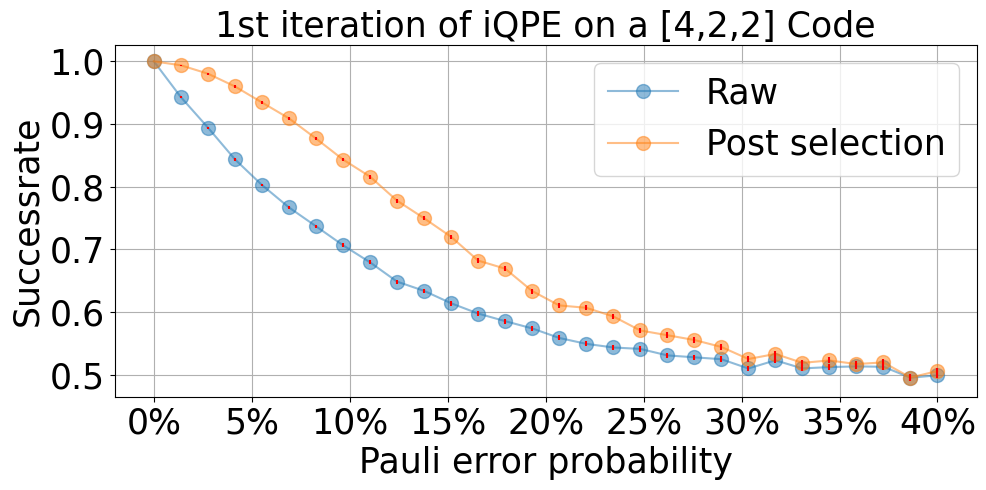

In [11]:
plot_x = np.linspace(0,0.4,30)
plot_y = []
plot_y_ps = []

shots = 10000

for i in range(len(plot_x)):
    q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, s_m, t_m    in this order
    qc = code()
    counts = iQPE_1(shots, plot_x[i])

    x = list(counts.keys())
    y = list(counts.values())

    all = 0

    ehm = 0
    for i in x:
        if int(i[6]) == 1:
            all += y[ehm]
        ehm += 1

    all = all/shots

    plot_y.append(all)

    check = [(i.count("1",0,6)%2-1) for i in x]

    check = [-i for i in check]

    y_new = np.multiply(check, y)

    all = 0

    for i in range(len(x)):
        if int(x[i][6]) == 1 and check[i] == 1:
            all += y_new[i]

    postselec = sum(y_new)

    all = all/postselec

    plot_y_ps.append(all)

err = [np.sqrt((i-i**2)/shots) for i in plot_x]

data = np.array((plot_x,plot_y,plot_y_ps))
np.savetxt("iQPE_1st_CSS.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 0))

ax.plot(plot_x,plot_y, label="Raw", marker = ".",markersize = 20, alpha = 0.5)
ax.plot(plot_x,plot_y_ps, label="Post selection", marker = ".",markersize = 20, alpha = 0.5)
ax = plt.errorbar(plot_x, plot_y, yerr=err, ecolor="red", linestyle="")
ax = plt.errorbar(plot_x, plot_y_ps, yerr=err, ecolor="red", linestyle="")
plt.title("1st iteration of iQPE on a [4,2,2] Code", fontsize=25)
plt.xlabel("Pauli error probability",fontsize=25)
plt.ylabel("Successrate",fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig("1.png", dpi = 200)
plt.show()

Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6), ('unitary', 4), ('if_else', 4), ('x', 2), ('t', 2), ('tdg', 1), ('sdg', 1)])
Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6), ('unitary', 4), ('if_else', 4), ('x', 2), ('t', 2), ('tdg', 1), ('sdg', 1)])
Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6), ('unitary', 4), ('if_else', 4), ('x', 2), ('t', 2), ('tdg', 1), ('sdg', 1)])
Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6), ('unitary', 4), ('if_else', 4), ('x', 2), ('t', 2), ('tdg', 1), ('sdg', 1)])
Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6), ('unitary', 4), ('if_else', 4), ('x', 2), ('t', 2), ('tdg', 1), ('sdg', 1)])
Amount of gates in this circuit:  53
OrderedDict([('cx', 12), ('reset', 12), ('measure', 9), ('h', 6

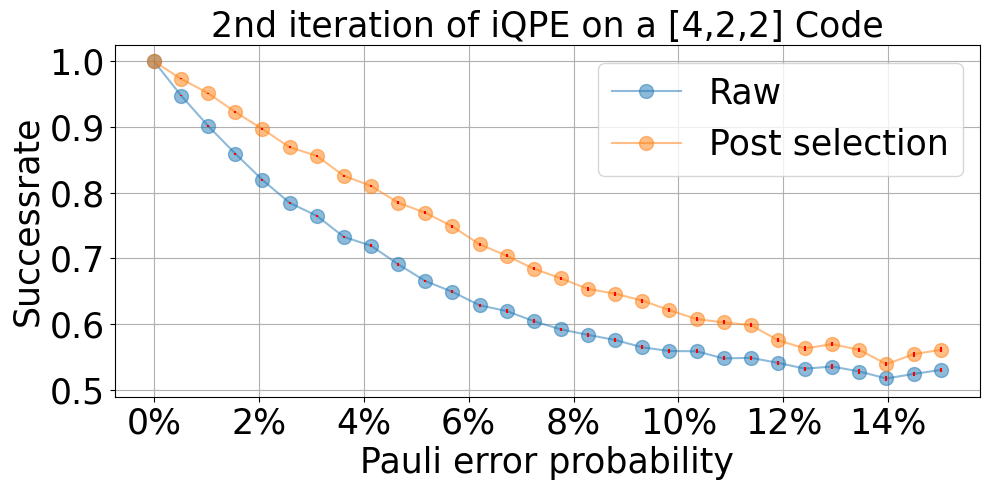

In [12]:
q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, s_m, t_m    in this order
qc = code()

plot_x = np.linspace(0,0.15,30)
plot_y = []
plot_y_ps = []

shots = 10000

for i in range(len(plot_x)):
    q = [0,1,2,3,4,5,6]         # = q0, q1, q2, q3, a, s_m, t_m    in this order
    qc = code()

    counts = iQPE_2(shots, plot_x[i])

    x = list(counts.keys())
    y = list(counts.values())

    all = 0

    ehm = 0
    for i in x:
        if int(i[6]) == 0:
            all += y[ehm]
        ehm += 1

    all = all/shots

    plot_y.append(all)

    check = [(i.count("1",0,6)%2-1) for i in x]

    check = [-i for i in check]

    y_new = np.multiply(check, y)

    all = 0

    for i in range(len(x)):
        if int(x[i][6]) == 0 and check[i] == 1:
            all += y_new[i]

    postselec = sum(y_new)

    all = all/postselec

    plot_y_ps.append(all)

err = [np.sqrt((i-i**2)/shots) for i in plot_x]

data = np.array((plot_x,plot_y,plot_y_ps))
np.savetxt("Plots/iQPE_2nd_CSS.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 0))

ax.plot(plot_x,plot_y, label="Raw", marker = ".",markersize = 20, alpha = 0.5)
ax.plot(plot_x,plot_y_ps, label="Post selection", marker = ".",markersize = 20, alpha = 0.5)
ax = plt.errorbar(plot_x, plot_y, yerr=err, ecolor="red", linestyle="")
ax = plt.errorbar(plot_x, plot_y_ps, yerr=err, ecolor="red", linestyle="")
plt.title("2nd iteration of iQPE on a [4,2,2] Code", fontsize=25)
plt.xlabel("Pauli error probability",fontsize=25)
plt.ylabel("Successrate",fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig("2.png", dpi = 200)
plt.show()

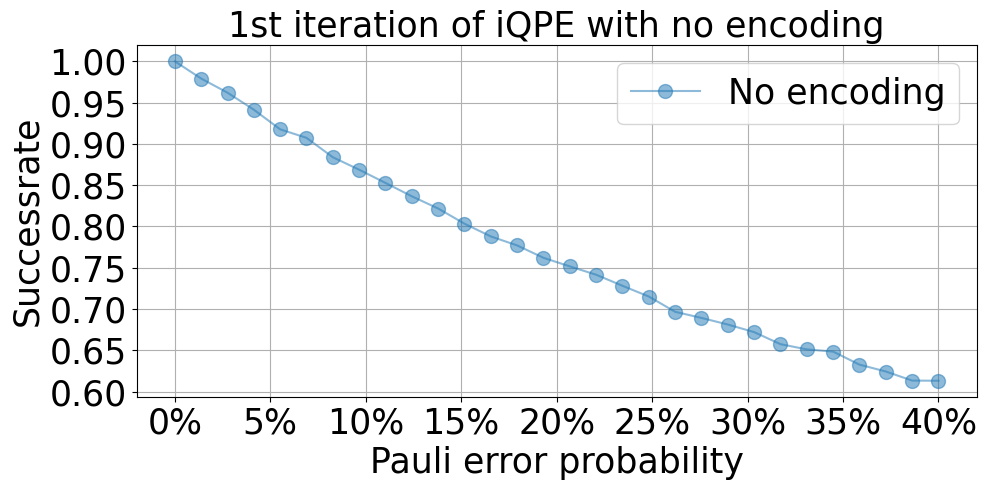

In [22]:
x = np.linspace(0,0.4,30)
y = []

shots = 10000

for i in x:
    qr = QuantumRegister(3)
    cbits = ClassicalRegister(1)

    qc = QuantumCircuit(qr,cbits)

    qc.h(0)
    qc.x(1)

    qc.cz(0,1)

    # qc.h(0)
    # qc.cx(1,0)
    # qc.h(0)

    qc.h(0)

    qc.measure(0,0)

    sim = AerSimulator()
    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    keys = list(counts.keys())
    counts = list(counts.values())

    nice = 0

    for i in range(len(keys)):
        if keys[i] == "1":
            nice += counts[i]
    y.append(nice/shots)


data = np.array((x,y))
np.savetxt("Plots/iQPE_1st_cz.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 0))

ax.plot(x,y, label="No encoding", marker = ".",markersize = 20, alpha = 0.5)
#ax = plt.errorbar(x, y, yerr=err, ecolor="red", linestyle="")
plt.title("1st iteration of iQPE with no encoding", fontsize=25)
plt.xlabel("Pauli error probability",fontsize=25)
plt.ylabel("Successrate",fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()

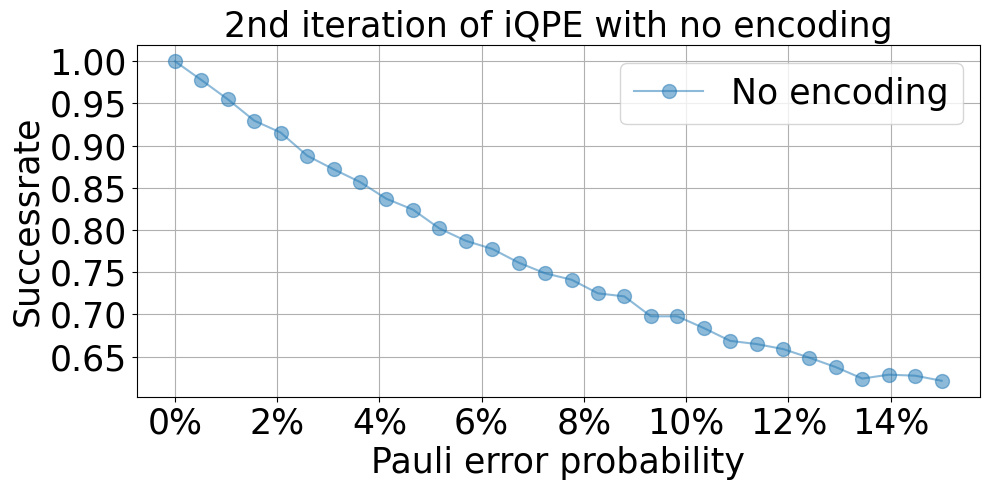

In [35]:
x = np.linspace(0,0.15,30)
y = []

shots = 10000

for i in x:
    qr = QuantumRegister(3)
    cbits = ClassicalRegister(1)

    qc = QuantumCircuit(qr,cbits)

    qc.h(0)
    qc.x(1)

    qc.t(0)
    qc.t(1)
    qc.cx(0,1)
    qc.tdg(1)
    qc.cx(0,1)

    qc.sdg(0)

    qc.h(0)

    qc.measure(0,0)

    sim = AerSimulator()
    p = i
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "sdg", "t", "s", "tdg"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
    job = sim.run(qc, noise_model=noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    keys = list(counts.keys())
    counts = list(counts.values())

    nice = 0

    for i in range(len(keys)):
        if keys[i] == "0":
            nice += counts[i]
    y.append(nice/shots)


data = np.array((x,y))
np.savetxt("Plots/iQPE_2nd.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(10,5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 0))

ax.plot(x,y, label="No encoding", marker = ".",markersize = 20, alpha = 0.5)
plt.title("2nd iteration of iQPE with no encoding", fontsize=25)
plt.xlabel("Pauli error probability",fontsize=25)
plt.ylabel("Successrate",fontsize=25)
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25)
plt.grid()
plt.legend(fontsize=25)
plt.tight_layout()
plt.show()